In [2]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from transformers import OwlViTProcessor, OwlViTForObjectDetection
import matplotlib.patches as patches
from torchvision.ops import nms

# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [3]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "../../sam2/checkpoints/sam2.1_hiera_large.pt"
model_cfg = "../../sam2/sam2/configs/sam2.1/sam2.1_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [4]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

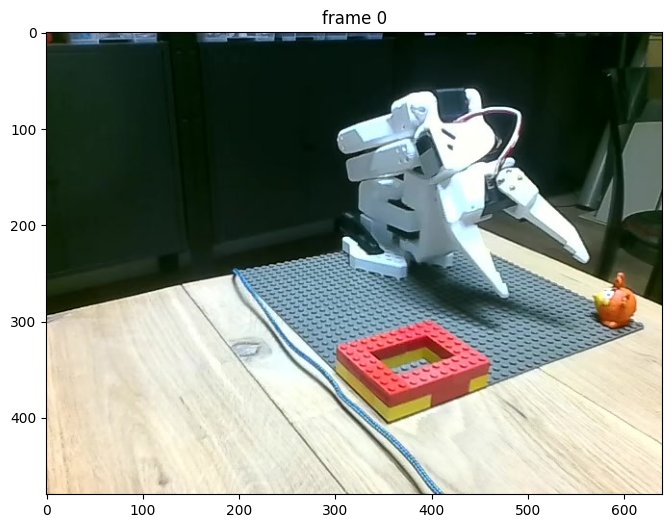

In [22]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "/home/v-shanmuwang/.cache/huggingface/lerobot/koenvanwijk/orange50-variation-2/videos/chunk-000/" \
            "observation.images.phone/episode_000000_frames"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

Detected an orange small toy with confidence 0.108 at location [567.24, 248.02, 618.8, 309.6]
Detected a red and yellow brick hole with confidence 0.023 at location [301.53, 298.56, 459.19, 402.0]


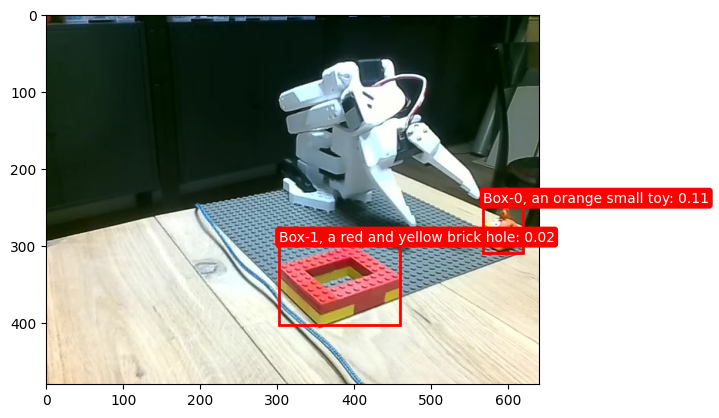

In [23]:
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")

image = Image.open(os.path.join(video_dir, frame_names[frame_idx]))
texts = [["an orange small toy" , "a red and yellow brick hole"]]
inputs = processor(text=texts, images=image, return_tensors="pt")
outputs = model(**inputs)

# Target image sizes (height, width) to rescale box predictions [batch_size, 2]
target_sizes = torch.Tensor([image.size[::-1]])
# Convert outputs (bounding boxes and class logits) to COCO API
results = processor.post_process_object_detection(outputs=outputs, threshold=0.015, target_sizes=target_sizes)

i = 0  # Retrieve predictions for the first image for the corresponding text queries
text = texts[i]
boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]

# Define the IoU threshold for NMS (e.g., 0.5 means suppress boxes with IoU > 0.5)
iou_threshold = 0.5

# Run NMS - note: boxes must be in [x1, y1, x2, y2] format
keep_indices = nms(boxes, scores, iou_threshold)

# Filter boxes, scores, and labels after NMS
boxes = boxes[keep_indices]
scores = scores[keep_indices]
labels = labels[keep_indices]

# Print detected objects and rescaled box coordinates
for box, score, label in zip(boxes, scores, labels):
    box = [round(i, 2) for i in box.tolist()]
    print(f"Detected {text[label]} with confidence {round(score.item(), 3)} at location {box}")

# Display the image
fig, ax = plt.subplots(1)
ax.imshow(image)

# Plot each detected bounding box
box_idx = 0
for box, score, label in zip(boxes, scores, labels):
    # Unpack box coordinates
    x0, y0, x1, y1 = box.tolist()
    width, height = x1 - x0, y1 - y0

    # Create a rectangle patch
    rect = patches.Rectangle((x0, y0), width, height, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)

    # Add label and score
    label_text = f"Box-{box_idx}, {text[label]}: {score:.2f}"
    ax.text(x0, y0 - 5, label_text, color='white', fontsize=10,
            bbox=dict(facecolor='red', edgecolor='red', boxstyle='round,pad=0.2'))
    box_idx += 1
plt.show()

In [24]:
inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG):   3%|▎         | 4/127 [00:00<00:03, 36.39it/s]

frame loading (JPEG): 100%|██████████| 127/127 [00:03<00:00, 34.89it/s]


In [25]:
predictor.reset_state(inference_state)

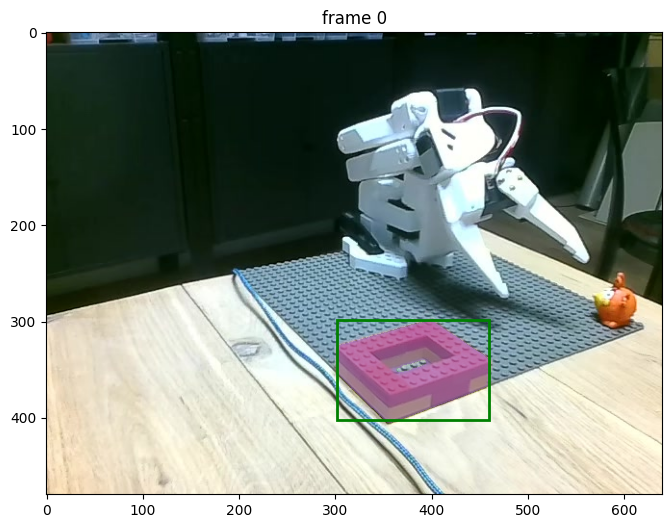

In [8]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 4  # give a unique id to each object we interact with (it can be any integers)

# Let's add a box at (x_min, y_min, x_max, y_max) = (300, 0, 500, 400) to get started
box = boxes[1].detach().cpu().numpy()  # use the first box from the detection results
# box = np.array([300, 0, 500, 400], dtype=np.float32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    box=box,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_box(box, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

propagate in video: 100%|██████████| 127/127 [00:44<00:00,  2.87it/s]


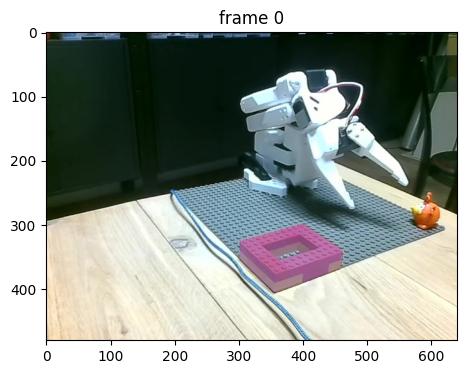

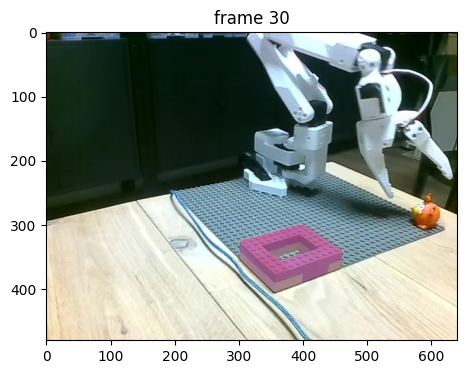

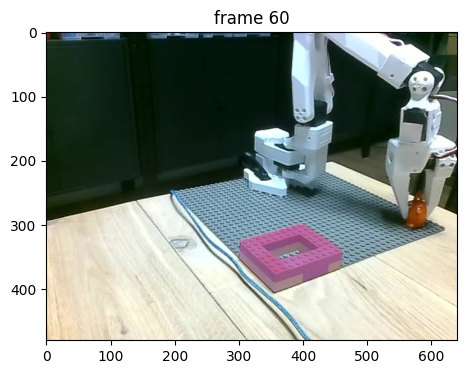

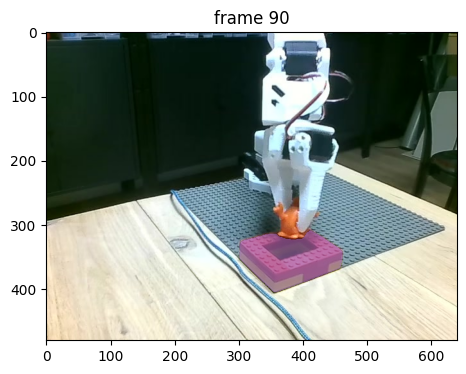

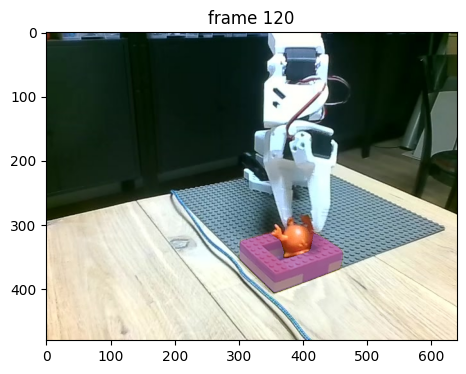

In [9]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 30
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

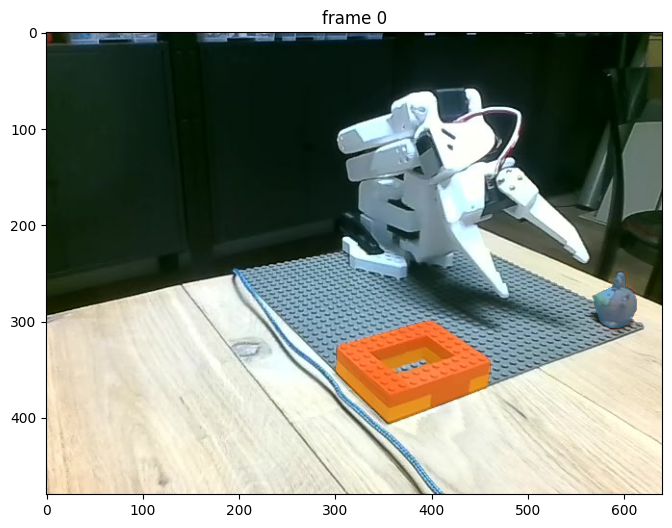

In [26]:
predictor.reset_state(inference_state)

prompts = {}  # hold all the clicks we add for visualization

# add the first object
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

box = boxes[1].detach().cpu().numpy()  # use the first box from the detection results
prompts[ann_obj_id] = box, labels
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    box=box,
)

ann_obj_id = 0
# Let's now move on to the second object we want to track (giving it object id `3`)
box = boxes[0].detach().cpu().numpy()  # use the first box from the detection results
prompts[ann_obj_id] = box, labels

# `add_new_points_or_box` returns masks for all objects added so far on this interacted frame
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    box=box,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
for i, out_obj_id in enumerate(out_obj_ids):
    show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)

In [ ]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 30
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)
    # # save figures into a folder
    # os.makedirs("video_segments", exist_ok=True)
    # plt.savefig(f"video_segments/frame_{out_frame_idx:04d}.png")
    # plt.close()

In [11]:
# print all the key-value pairs in `video_segments`
for out_frame_idx, masks in video_segments.items():
    print(f"Frame {out_frame_idx}:")
    for out_obj_id, mask in masks.items():
        print(f"  Object {out_obj_id}: {mask.shape} - {mask.sum()} pixels") # mask elements: Ture/False
    print()

Frame 0:
  Object 1: (1, 480, 640) - 11012 pixels
  Object 0: (1, 480, 640) - 1732 pixels

Frame 1:
  Object 1: (1, 480, 640) - 10953 pixels
  Object 0: (1, 480, 640) - 1733 pixels

Frame 2:
  Object 1: (1, 480, 640) - 10932 pixels
  Object 0: (1, 480, 640) - 1728 pixels

Frame 3:
  Object 1: (1, 480, 640) - 10933 pixels
  Object 0: (1, 480, 640) - 1727 pixels

Frame 4:
  Object 1: (1, 480, 640) - 10932 pixels
  Object 0: (1, 480, 640) - 1719 pixels

Frame 5:
  Object 1: (1, 480, 640) - 10929 pixels
  Object 0: (1, 480, 640) - 1720 pixels

Frame 6:
  Object 1: (1, 480, 640) - 11034 pixels
  Object 0: (1, 480, 640) - 1750 pixels

Frame 7:
  Object 1: (1, 480, 640) - 11031 pixels
  Object 0: (1, 480, 640) - 1750 pixels

Frame 8:
  Object 1: (1, 480, 640) - 11008 pixels
  Object 0: (1, 480, 640) - 1764 pixels

Frame 9:
  Object 1: (1, 480, 640) - 10835 pixels
  Object 0: (1, 480, 640) - 1763 pixels

Frame 10:
  Object 1: (1, 480, 640) - 11017 pixels
  Object 0: (1, 480, 640) - 1734 pixels

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os

# temperature values (0–255 scale)
TEMP_OBJ1 = 240  # high temperature
TEMP_OBJ2 = 120  # low temperature
TEMP_BG   = 20   # cold background

# visualize every N frames
vis_frame_stride = 1
plt.close("all")

for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    # Load the original frame
    rgb_img = np.array(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    
    # Initialize the synthetic heatmap as all-background
    heatmap = np.full((rgb_img.shape[0], rgb_img.shape[1]), fill_value=TEMP_BG, dtype=np.uint8)

    # Assign high/low temperatures based on object ID
    frame_masks = video_segments[out_frame_idx]
    for obj_id, mask in frame_masks.items():
        mask2d = mask.squeeze(0)
        if obj_id == 0:
            heatmap[mask2d] = TEMP_OBJ1
        elif obj_id == 1:
            heatmap[mask2d] = TEMP_OBJ2

    # blur the heatmap for realism (simulate thermal diffusion)
    heatmap_blurred = cv2.GaussianBlur(heatmap, (21, 21), sigmaX=0)

    # Apply a thermal colormap (e.g., inferno, hot, jet)
    thermal_color = cv2.applyColorMap(heatmap_blurred, cv2.COLORMAP_INFERNO)

    # Display side-by-side
    combined = np.hstack((rgb_img, thermal_color))
    
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(combined)
    # plt.savefig(f"video_segments/thermal_frame_{out_frame_idx:04d}.png")
    # plt.close()

In [33]:
# generate a GIF from the saved thermal frames
import imageio

import imageio.v2 as imageio

def create_gif_from_frames(frame_folder, output_gif, fps=30):
    # Collect all frame images
    frames = []
    for filename in sorted(os.listdir(frame_folder)):
        if filename.endswith(".png"):
            frames.append(imageio.imread(os.path.join(frame_folder, filename)))

    # Save as GIF
    duration = 1.0 / fps  # duration per frame in seconds
    imageio.mimsave(output_gif, frames, duration=duration)

# create a GIF from the saved thermal frames
create_gif_from_frames("video_segments", "segment_video.gif", fps=30)